In [2]:
# Setup

import os
import textwrap as tr

import nest_asyncio
from azure.identity import DefaultAzureCredential, ManagedIdentityCredential
from azure.keyvault.secrets import SecretClient
from dotenv import load_dotenv
from llama_index.core import ServiceContext, set_global_service_context
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.core.prompts import ChatMessage, ChatPromptTemplate, MessageRole
from tqdm import tqdm

# This is a hack to get some things to work in Jupyter Notebooks
nest_asyncio.apply()

def pwrap(text):
    print(tr.fill(str(text), width=80))

# Load environment variables from .env file
try:
    load_dotenv(dotenv_path=".env")
except:
    pass

# If we're running on Azure, use the Managed Identity to get the secrets
# if os.environ.get("CREDENTIAL_TYPE").lower() == "managed":
#     credential = ManagedIdentityCredential()
# else:
#     credential = DefaultAzureCredential()

# # Login to KeyVault using Azure credentials
# client = SecretClient(
#     vault_url=os.environ.get("AZURE_KEYVAULT_URL"), credential=credential
# )

OPENAI_API_BASE = os.environ.get("AZURE_OPENAI_ENDPOINT")
OPENAI_API_VERSION = os.environ.get("AZURE_OPENAI_VERSION")
# OPENAI_API_KEY = client.get_secret("OPENAI-SERVICE-KEY").value
OPENAI_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY")

api_key = OPENAI_API_KEY
azure_endpoint = OPENAI_API_BASE
api_version = OPENAI_API_VERSION


llm = AzureOpenAI(
    model="gpt-35-turbo",
    deployment_name="gpt-35-turbo",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

# You need to deploy your own embedding model as well as your own chat completion model
embed_model = AzureOpenAIEmbedding(
    model="text-embedding-3-large",
    deployment_name="text-embedding-3-large",
    # dimensions=1024,
    embed_batch_size=16,
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

from llama_index.core import set_global_service_context

service_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model=embed_model,
)

set_global_service_context(service_context)

C:\Users\JKuehn\AppData\Local\Temp\ipykernel_93392\285261612.py:70: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('small_df.csv')

df.columns

from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
from llama_index.core.schema import MetadataMode, TextNode
import uuid

eng_nodes = [TextNode(id=row['section_id'], text=row['text_combined_eng']) for index, row in df.iterrows()]
fra_nodes = [TextNode(id=row['section_id'], text=row['text_combined_fra']) for index, row in df.iterrows()]
eng_questions_easy = df['easy_eng_queries'].tolist()
eng_questions_hard = df['hard_eng_queries'].tolist()
fra_questions_easy = df['easy_fra_queries'].tolist()
fra_questions_hard = df['hard_fra_queries'].tolist()

def build_eval_dataset(nodes, questions):
    """Takes nodes and questions: 2 lists of the same length"""
    node_dict = {
        node.node_id: node.get_content(metadata_mode=MetadataMode.NONE)
        for node in nodes
    }
    queries = {}
    relevant_docs = {}

    for node, question in zip(nodes, questions):
        question_id = str(uuid.uuid4())
        queries[question_id] = question
        relevant_docs[question_id] = [node.node_id]

    # construct dataset
    return EmbeddingQAFinetuneDataset(
        queries=queries, corpus=node_dict, relevant_docs=relevant_docs
    )

# TODO: add multi-language corpus
# eng_to_eng_easy = build_eval_dataset(eng_nodes, eng_questions_easy)
eng_to_eng_hard = build_eval_dataset(eng_nodes, eng_questions_hard)
# fra_to_fra_easy = build_eval_dataset(fra_nodes, fra_questions_easy)
fra_to_fra_hard = build_eval_dataset(fra_nodes, fra_questions_hard)
# eng_to_fra_easy = build_eval_dataset(eng_nodes, fra_questions_easy)
# eng_to_fra_hard = build_eval_dataset(eng_nodes, fra_questions_hard)
# fra_to_eng_easy = build_eval_dataset(fra_nodes, eng_questions_easy)
# fra_to_eng_hard = build_eval_dataset(fra_nodes, eng_questions_hard)

In [4]:

# Weaviate base.py
# Changed to use relative score fusion 

"""Weaviate Vector store index.

An index that is built on top of an existing vector store.

"""

import logging
from typing import Any, Dict, List, Optional, cast
from uuid import uuid4

from llama_index.core.bridge.pydantic import Field, PrivateAttr
from llama_index.core.schema import BaseNode
from llama_index.core.vector_stores.types import (
    BasePydanticVectorStore,
    MetadataFilters,
    VectorStoreQuery,
    VectorStoreQueryMode,
    VectorStoreQueryResult,
)
from llama_index.core.vector_stores.utils import DEFAULT_TEXT_KEY
from llama_index.vector_stores.weaviate.utils import (
    add_node,
    class_schema_exists,
    create_default_schema,
    get_all_properties,
    get_node_similarity,
    parse_get_response,
    to_node,
)

import weaviate  # noqa
from weaviate import AuthApiKey, Client
from weaviate.gql.get import HybridFusion

logger = logging.getLogger(__name__)


def _transform_weaviate_filter_condition(condition: str) -> str:
    """Translate standard metadata filter op to Chroma specific spec."""
    if condition == "and":
        return "And"
    elif condition == "or":
        return "Or"
    else:
        raise ValueError(f"Filter condition {condition} not supported")


def _transform_weaviate_filter_operator(operator: str) -> str:
    """Translate standard metadata filter operator to Chroma specific spec."""
    if operator == "!=":
        return "NotEqual"
    elif operator == "==":
        return "Equal"
    elif operator == ">":
        return "GreaterThan"
    elif operator == "<":
        return "LessThan"
    elif operator == ">=":
        return "GreaterThanEqual"
    elif operator == "<=":
        return "LessThanEqual"
    else:
        raise ValueError(f"Filter operator {operator} not supported")


def _to_weaviate_filter(standard_filters: MetadataFilters) -> Dict[str, Any]:
    filters_list = []
    condition = standard_filters.condition or "and"
    condition = _transform_weaviate_filter_condition(condition)

    if standard_filters.filters:
        for filter in standard_filters.filters:
            value_type = "valueText"
            if isinstance(filter.value, float):
                value_type = "valueNumber"
            elif isinstance(filter.value, int):
                value_type = "valueInt"
            elif isinstance(filter.value, str) and filter.value.isnumeric():
                filter.value = float(filter.value)
                value_type = "valueNumber"
            filters_list.append(
                {
                    "path": filter.key,
                    "operator": _transform_weaviate_filter_operator(filter.operator),
                    value_type: filter.value,
                }
            )
    else:
        return {}

    if len(filters_list) == 1:
        # If there is only one filter, return it directly
        return filters_list[0]

    return {"operands": filters_list, "operator": condition}


class WeaviateVectorStore(BasePydanticVectorStore):
    """Weaviate vector store.

    In this vector store, embeddings and docs are stored within a
    Weaviate collection.

    During query time, the index uses Weaviate to query for the top
    k most similar nodes.

    Args:
        weaviate_client (weaviate.Client): WeaviateClient
            instance from `weaviate-client` package
        index_name (Optional[str]): name for Weaviate classes

    """

    stores_text: bool = True

    index_name: str
    url: Optional[str]
    text_key: str
    auth_config: Dict[str, Any] = Field(default_factory=dict)
    client_kwargs: Dict[str, Any] = Field(default_factory=dict)

    _client = PrivateAttr()

    def __init__(
        self,
        weaviate_client: Optional[Any] = None,
        class_prefix: Optional[str] = None,
        index_name: Optional[str] = None,
        text_key: str = DEFAULT_TEXT_KEY,
        auth_config: Optional[Any] = None,
        client_kwargs: Optional[Dict[str, Any]] = None,
        url: Optional[str] = None,
        **kwargs: Any,
    ) -> None:
        """Initialize params."""
        if weaviate_client is None:
            if isinstance(auth_config, dict):
                auth_config = AuthApiKey(**auth_config)

            client_kwargs = client_kwargs or {}
            self._client = Client(
                url=url, auth_client_secret=auth_config, **client_kwargs
            )
        else:
            self._client = cast(Client, weaviate_client)

        # validate class prefix starts with a capital letter
        if class_prefix is not None:
            logger.warning("class_prefix is deprecated, please use index_name")
            # legacy, kept for backward compatibility
            index_name = f"{class_prefix}_Node"

        index_name = index_name or f"LlamaIndex_{uuid4().hex}"
        if not index_name[0].isupper():
            raise ValueError(
                "Index name must start with a capital letter, e.g. 'LlamaIndex'"
            )

        # create default schema if does not exist
        if not class_schema_exists(self._client, index_name):
            create_default_schema(self._client, index_name)

        super().__init__(
            url=url,
            index_name=index_name,
            text_key=text_key,
            auth_config=auth_config.__dict__ if auth_config else {},
            client_kwargs=client_kwargs or {},
        )

    @classmethod
    def from_params(
        cls,
        url: str,
        auth_config: Any,
        index_name: Optional[str] = None,
        text_key: str = DEFAULT_TEXT_KEY,
        client_kwargs: Optional[Dict[str, Any]] = None,
        **kwargs: Any,
    ) -> "WeaviateVectorStore":
        """Create WeaviateVectorStore from config."""
        client_kwargs = client_kwargs or {}
        weaviate_client = Client(
            url=url, auth_client_secret=auth_config, **client_kwargs
        )
        return cls(
            weaviate_client=weaviate_client,
            url=url,
            auth_config=auth_config.__dict__,
            client_kwargs=client_kwargs,
            index_name=index_name,
            text_key=text_key,
            **kwargs,
        )

    @classmethod
    def class_name(cls) -> str:
        return "WeaviateVectorStore"

    @property
    def client(self) -> Any:
        """Get client."""
        return self._client

    def add(
        self,
        nodes: List[BaseNode],
        **add_kwargs: Any,
    ) -> List[str]:
        """Add nodes to index.

        Args:
            nodes: List[BaseNode]: list of nodes with embeddings

        """
        ids = [r.node_id for r in nodes]

        with self._client.batch as batch:
            for node in nodes:
                add_node(
                    self._client,
                    node,
                    self.index_name,
                    batch=batch,
                    text_key=self.text_key,
                )
        return ids

    def delete(self, ref_doc_id: str, **delete_kwargs: Any) -> None:
        """
        Delete nodes using with ref_doc_id.

        Args:
            ref_doc_id (str): The doc_id of the document to delete.

        """
        where_filter = {
            "path": ["ref_doc_id"],
            "operator": "Equal",
            "valueText": ref_doc_id,
        }
        if "filter" in delete_kwargs and delete_kwargs["filter"] is not None:
            where_filter = {
                "operator": "And",
                "operands": [where_filter, delete_kwargs["filter"]],  # type: ignore
            }

        query = (
            self._client.query.get(self.index_name)
            .with_additional(["id"])
            .with_where(where_filter)
            .with_limit(10000)  # 10,000 is the max weaviate can fetch
        )

        query_result = query.do()
        parsed_result = parse_get_response(query_result)
        entries = parsed_result[self.index_name]
        for entry in entries:
            self._client.data_object.delete(entry["_additional"]["id"], self.index_name)

    def query(self, query: VectorStoreQuery, **kwargs: Any) -> VectorStoreQueryResult:
        """Query index for top k most similar nodes."""
        all_properties = get_all_properties(self._client, self.index_name)

        # build query
        query_builder = self._client.query.get(self.index_name, all_properties)

        # list of documents to constrain search
        if query.doc_ids:
            filter_with_doc_ids = {
                "operator": "Or",
                "operands": [
                    {"path": ["doc_id"], "operator": "Equal", "valueText": doc_id}
                    for doc_id in query.doc_ids
                ],
            }
            query_builder = query_builder.with_where(filter_with_doc_ids)

        if query.node_ids:
            filter_with_node_ids = {
                "operator": "Or",
                "operands": [
                    {"path": ["id"], "operator": "Equal", "valueText": node_id}
                    for node_id in query.node_ids
                ],
            }
            query_builder = query_builder.with_where(filter_with_node_ids)

        query_builder = query_builder.with_additional(
            ["id", "vector", "distance", "score"]
        )

        vector = query.query_embedding
        similarity_key = "distance"
        if query.mode == VectorStoreQueryMode.DEFAULT:
            logger.debug("Using vector search")
            if vector is not None:
                query_builder = query_builder.with_near_vector(
                    {
                        "vector": vector,
                    }
                )
        elif query.mode == VectorStoreQueryMode.HYBRID:
            logger.debug(f"Using hybrid search with alpha {query.alpha}")
            similarity_key = "score"
            if vector is not None and query.query_str:
                query_builder = query_builder.with_hybrid(
                    query=query.query_str,
                    alpha=query.alpha,
                    vector=vector,
                    fusion_type=HybridFusion.RELATIVE_SCORE,
                )

        if query.filters is not None:
            filter = _to_weaviate_filter(query.filters)
            query_builder = query_builder.with_where(filter)
        elif "filter" in kwargs and kwargs["filter"] is not None:
            query_builder = query_builder.with_where(kwargs["filter"])

        query_builder = query_builder.with_limit(query.similarity_top_k)
        logger.debug(f"Using limit of {query.similarity_top_k}")

        # execute query
        query_result = query_builder.do()

        # parse results
        parsed_result = parse_get_response(query_result)
        entries = parsed_result[self.index_name]

        similarities = []
        nodes: List[BaseNode] = []
        node_ids = []

        for i, entry in enumerate(entries):
            if i < query.similarity_top_k:
                similarities.append(get_node_similarity(entry, similarity_key))
                nodes.append(to_node(entry, text_key=self.text_key))
                node_ids.append(nodes[-1].node_id)
            else:
                break

        return VectorStoreQueryResult(
            nodes=nodes, ids=node_ids, similarities=similarities
        )


In [6]:
import weaviate

client = weaviate.Client("http://localhost:8080")

from llama_index.core import (
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)

client.schema.delete_class("LawsCLIR")
eng_vector_store = WeaviateVectorStore(
    weaviate_client=client, index_name="LawsCLIR"
)
eng_index = VectorStoreIndex.from_vector_store(
    eng_vector_store, embed_model=embed_model
)
eng_index.insert_nodes(eng_nodes)

C:\Users\JKuehn\AppData\Roaming\Python\Python311\site-packages\weaviate\warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.2. The latest version is 4.5.5.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


In [7]:
from llama_index.core.evaluation import RetrieverEvaluator
import pandas as pd

def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    columns = {"retrievers": [name], "hit_rate": [hit_rate], "mrr": [mrr]}

    # if include_cohere_rerank:
    #     crr_relevancy = full_df["cohere_rerank_relevancy"].mean()
    #     columns.update({"cohere_rerank_relevancy": [crr_relevancy]})

    metric_df = pd.DataFrame(columns)

    return metric_df

metrics = ["mrr", "hit_rate"]

eng_retriever = eng_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    alpha=0.7,
)

eng_hybrid_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_retriever,
)

In [9]:
eng_hybrid = await eng_hybrid_evaluator.aevaluate_dataset(eng_to_eng_hard)

result1 = display_results("eng_hybrid", eng_hybrid)
result1["test_set"] = "eng_to_eng_hard"

result1

,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard


In [11]:
eng_vector_retriever = eng_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    alpha=1,
)

eng_vector_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_vector_retriever,
)

eng_vector = await eng_vector_evaluator.aevaluate_dataset(eng_to_eng_hard)

result2 = display_results("eng_vector", eng_vector)
result2["test_set"] = "eng_to_eng_hard"

pd.concat([result1, result2])

,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard
0,eng_vector,0.992,0.958650,eng_to_eng_hard


In [12]:
eng_more_bm25_retriever = eng_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    alpha=0.3,
)

eng_more_bm25_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_more_bm25_retriever,
)

eng_bm25 = await eng_more_bm25_evaluator.aevaluate_dataset(eng_to_eng_hard)

result3 = display_results("eng_bm25", eng_bm25)
result3["test_set"] = "eng_to_eng_hard"

pd.concat([result1, result2, result3])

,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard
0,eng_vector,0.992,0.958650,eng_to_eng_hard
0,eng_bm25,0.915,0.791517,eng_to_eng_hard


In [13]:
client.schema.delete_class("LawsCLIRfr")
fra_vector_store = WeaviateVectorStore(
    weaviate_client=client, index_name="LawsCLIRfr"
)
fra_index = VectorStoreIndex.from_vector_store(
    fra_vector_store, embed_model=embed_model
)
fra_index.insert_nodes(fra_nodes)

In [14]:
fra_retriever = fra_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    alpha=0.7,
)

fra_hybrid_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_retriever,
)

fra_hybrid = await fra_hybrid_evaluator.aevaluate_dataset(fra_to_fra_hard)

result4 = display_results("fra_hybrid", fra_hybrid)

result4["test_set"] = "fra_to_fra_hard"

pd.concat([result1, result2, result3, result4])

,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard
0,eng_vector,0.992,0.958650,eng_to_eng_hard
0,eng_bm25,0.915,0.791517,eng_to_eng_hard
0,fra_hybrid,0.985,0.931417,fra_to_fra_hard


In [15]:
fra_vector_retriever = fra_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    alpha=1,
)

fra_vector_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_vector_retriever,
)

fra_vector = await fra_vector_evaluator.aevaluate_dataset(fra_to_fra_hard)

result5 = display_results("fra_vector", fra_vector)

result5["test_set"] = "fra_to_fra_hard"

pd.concat([result1, result2, result3, result4, result5])

,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard
0,eng_vector,0.992,0.958650,eng_to_eng_hard
0,eng_bm25,0.915,0.791517,eng_to_eng_hard
0,fra_hybrid,0.985,0.931417,fra_to_fra_hard
0,fra_vector,0.977,0.924833,fra_to_fra_hard


In [16]:
fra_more_bm25_retriever = fra_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    alpha=0.3,
)

fra_more_bm25_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_more_bm25_retriever,
)

fra_bm25 = await fra_more_bm25_evaluator.aevaluate_dataset(fra_to_fra_hard)

result6 = display_results("fra_bm25", fra_bm25)

result6["test_set"] = "fra_to_fra_hard"

pd.concat([result1, result2, result3, result4, result5, result6])

,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard
0,eng_vector,0.992,0.958650,eng_to_eng_hard
0,eng_bm25,0.915,0.791517,eng_to_eng_hard
0,fra_hybrid,0.985,0.931417,fra_to_fra_hard
0,fra_vector,0.977,0.924833,fra_to_fra_hard
0,fra_bm25,0.899,0.767817,fra_to_fra_hard


In [17]:
eng_to_fra_hard = build_eval_dataset(eng_nodes, fra_questions_hard)
fra_to_eng_hard = build_eval_dataset(fra_nodes, eng_questions_hard)

eng_to_fra_retriever = eng_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    alpha=0.7,
)

eng_to_fra_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_to_fra_retriever,
)

eng_to_fra = await eng_to_fra_evaluator.aevaluate_dataset(eng_to_fra_hard)

result7 = display_results("french_q_english_corpus_hybrid", eng_to_fra)

In [18]:
fra_to_eng = await fra_hybrid_evaluator.aevaluate_dataset(fra_to_eng_hard)

result8 = display_results("english_q_french_corpus_hybrid", fra_to_eng)

pd.concat([result1, result2, result3, result4, result5, result6, result7, result8])

,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard
0,eng_vector,0.992,0.958650,eng_to_eng_hard
0,eng_bm25,0.915,0.791517,eng_to_eng_hard
0,fra_hybrid,0.985,0.931417,fra_to_fra_hard
0,fra_vector,0.977,0.924833,fra_to_fra_hard
0,fra_bm25,0.899,0.767817,fra_to_fra_hard
0,french_q_english_corpus_hybrid,0.960,0.874967,NaN
0,english_q_french_corpus_hybrid,0.988,0.931717,NaN


In [19]:
eng_to_fra_vector = await eng_vector_evaluator.aevaluate_dataset(eng_to_fra_hard)
fra_to_eng_vector = await fra_vector_evaluator.aevaluate_dataset(fra_to_eng_hard)

result9 = display_results("french_q_english_corpus_vector", eng_to_fra_vector)
result10 = display_results("english_q_french_corpus_vector", fra_to_eng_vector)

pd.concat([result1, result2, result3, result4, result5, result6, result7, result8, result9, result10])


,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard
0,eng_vector,0.992,0.958650,eng_to_eng_hard
0,eng_bm25,0.915,0.791517,eng_to_eng_hard
0,fra_hybrid,0.985,0.931417,fra_to_fra_hard
0,fra_vector,0.977,0.924833,fra_to_fra_hard
0,fra_bm25,0.899,0.767817,fra_to_fra_hard
0,french_q_english_corpus_hybrid,0.960,0.874967,NaN
0,english_q_french_corpus_hybrid,0.988,0.931717,NaN
0,french_q_english_corpus_vector,0.959,0.883433,NaN
0,english_q_french_corpus_vector,0.981,0.935383,NaN


In [23]:
new_results = pd.concat([result1, result2, result3, result4, result5, result6, result7, result8, result9, result10])
new_results.reset_index(drop=True, inplace=True)
new_results.loc[6, "test_set"] = "eng_to_fra_hard"
new_results.loc[7, "test_set"] = "fra_to_eng_hard"
new_results.loc[8, "test_set"] = "eng_to_fra_hard"
new_results.loc[9, "test_set"] = "fra_to_eng_hard"

new_results.loc[6, "retrievers"] = "eng_hybrid"
new_results.loc[7, "retrievers"] = "fra_hybrid"
new_results.loc[8, "retrievers"] = "eng_vector"
new_results.loc[9, "retrievers"] = "fra_vector"

new_results

,retrievers,hit_rate,mrr,test_set
0,eng_hybrid,0.992,0.958367,eng_to_eng_hard
1,eng_vector,0.992,0.958650,eng_to_eng_hard
2,eng_bm25,0.915,0.791517,eng_to_eng_hard
3,fra_hybrid,0.985,0.931417,fra_to_fra_hard
4,fra_vector,0.977,0.924833,fra_to_fra_hard
5,fra_bm25,0.899,0.767817,fra_to_fra_hard
6,eng_hybrid,0.960,0.874967,eng_to_fra_hard
7,fra_hybrid,0.988,0.931717,fra_to_eng_hard
8,eng_vector,0.959,0.883433,eng_to_fra_hard
9,fra_vector,0.981,0.935383,fra_to_eng_hard


In [39]:
# Read the baseline-results.csv file
baseline_results = pd.read_csv('baseline_results.csv')

# Reformat the new_results columns
# Nicer labels for the results
column_mapping = {
    "retrievers": "Retriever",
    "hit_rate": "Hit Rate",
    "mrr": "Mean Reciprocal Rank",
    "test_set": "Queries",
}
value_mapping = {
    "fra_bm25": "Favor BM25 (French)",
    "eng_bm25": "Favor BM25 (English)",
    "fra_vector": "Vector Large (French)",
    "eng_vector": "Vector Large (English)",
    "eng_hybrid": "Hybrid (English)",
    "fra_hybrid": "Hybrid (French)",
    "eng_to_eng_easy": "English (Easy)",
    "eng_to_eng_hard": "English (Hard)",
    "fra_to_fra_easy": "French (Easy)",
    "fra_to_fra_hard": "French (Hard)",
    "eng_to_fra_easy": "English (Easy)",
    "eng_to_fra_hard": "English (Hard)",
    "fra_to_eng_easy": "French (Easy)",
    "fra_to_eng_hard": "French (Hard)",
}

result_cross2 = new_results.rename(columns=column_mapping)
result_cross2 = result_cross2.replace(value_mapping)

# Split the columns so that "BM25 (French)" becomes two columns: "Retriever: BM25" and "Corpus language: French"
result_cross2["Corpus language"] = result_cross2["Retriever"].str.split(" \(").str[1].str[:-1]
result_cross2["Retriever"] = result_cross2["Retriever"].str.split(" \(").str[0]

# Split the columns so that "English (Easy)" becomes two columns: "Query language: English" and "Query difficulty: Easy"
result_cross2["Query language"] = result_cross2["Queries"].str.split(" \(").str[0]
result_cross2["Query difficulty"] = result_cross2["Queries"].str.split(" \(").str[1].str[:-1]

result_cross2 = result_cross2[
    ['Corpus language', 'Query language', 'Query difficulty', 'Retriever', 'Hit Rate', 'Mean Reciprocal Rank']
]

result_cross2.reset_index(inplace=True, drop=True)

"""
0	french_q_english_corpus_hybrid	0.960	0.874967	NaN
0	english_q_french_corpus_hybrid	0.988	0.931717	NaN
0	french_q_english_corpus_vector	0.959	0.883433	NaN
0	english_q_french_corpus_vector	0.981	0.935383	NaN
"""

result_cross2.loc[6, "Corpus language"] = "English"
result_cross2.loc[7, "Corpus language"] = "French"
result_cross2.loc[8, "Corpus language"] = "English"
result_cross2.loc[9, "Corpus language"] = "French"

result_cross2.loc[6, "Query language"] = "French"
result_cross2.loc[7, "Query language"] = "English"
result_cross2.loc[8, "Query language"] = "French"
result_cross2.loc[9, "Query language"] = "English"

result_cross2

<>:33: DeprecationWarning: invalid escape sequence '\('
<>:34: DeprecationWarning: invalid escape sequence '\('
<>:37: DeprecationWarning: invalid escape sequence '\('
<>:38: DeprecationWarning: invalid escape sequence '\('
<>:33: DeprecationWarning: invalid escape sequence '\('
<>:34: DeprecationWarning: invalid escape sequence '\('
<>:37: DeprecationWarning: invalid escape sequence '\('
<>:38: DeprecationWarning: invalid escape sequence '\('
C:\Users\JKuehn\AppData\Local\Temp\ipykernel_93392\2739608518.py:33: DeprecationWarning: invalid escape sequence '\('
  result_cross2["Corpus language"] = result_cross2["Retriever"].str.split(" \(").str[1].str[:-1]
C:\Users\JKuehn\AppData\Local\Temp\ipykernel_93392\2739608518.py:34: DeprecationWarning: invalid escape sequence '\('
  result_cross2["Retriever"] = result_cross2["Retriever"].str.split(" \(").str[0]
C:\Users\JKuehn\AppData\Local\Temp\ipykernel_93392\2739608518.py:37: DeprecationWarning: invalid escape sequence '\('
  result_cross2["Qu

,Corpus language,Query language,Query difficulty,Retriever,Hit Rate,Mean Reciprocal Rank
0,English,English,Hard,Hybrid,0.992,0.958367
1,English,English,Hard,Vector Large,0.992,0.958650
2,English,English,Hard,Favor BM25,0.915,0.791517
3,French,French,Hard,Hybrid,0.985,0.931417
4,French,French,Hard,Vector Large,0.977,0.924833
5,French,French,Hard,Favor BM25,0.899,0.767817
6,English,French,Hard,Hybrid,0.960,0.874967
7,French,English,Hard,Hybrid,0.988,0.931717
8,English,French,Hard,Vector Large,0.959,0.883433
9,French,English,Hard,Vector Large,0.981,0.935383


In [40]:
all_results = pd.concat([baseline_results, result_cross2])
all_results

,Corpus language,Query language,Query difficulty,Retriever,Hit Rate,Mean Reciprocal Rank
0,English,English,Easy,BM25,0.995,0.968617
1,English,English,Easy,Vector,0.999,0.985583
2,English,English,Hard,BM25,0.884,0.771383
3,English,English,Hard,Vector,0.986,0.935700
4,English,French,Easy,BM25,0.136,0.053300
5,English,French,Easy,Vector,0.974,0.930783
6,English,French,Hard,BM25,0.148,0.078583
7,English,French,Hard,Vector,0.897,0.791333
8,French,English,Easy,BM25,0.438,0.314800
9,French,English,Easy,Vector,0.986,0.942900


Text(0.5, 1.0, 'English to English (hard)')

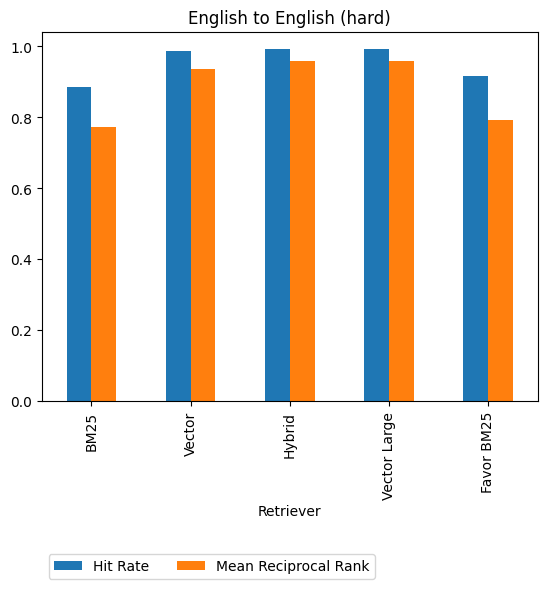

In [42]:
all_results[
    (all_results["Query language"] == "English")
    & (all_results["Corpus language"] == "English")
    & (all_results["Query difficulty"] == "Hard")
].set_index("Retriever", drop=True).plot.bar()

# Move legend to bottom left
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncol=2)
plt.title("English to English (hard)")

Text(0.5, 1.0, 'French to French (hard)')

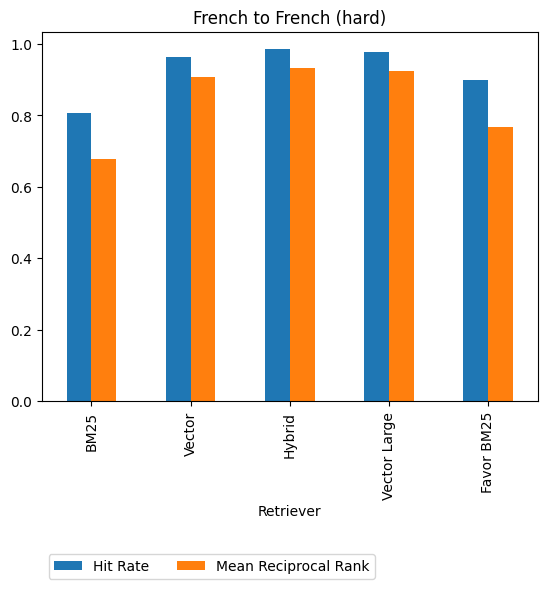

In [43]:
all_results[
    (all_results["Query language"] == "French")
    & (all_results["Corpus language"] == "French")
    & (all_results["Query difficulty"] == "Hard")
].set_index("Retriever", drop=True).plot.bar()

# Move legend to bottom left
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncol=2)
plt.title("French to French (hard)")

Text(0.5, 1.0, 'French queries, English corpus (hard)')

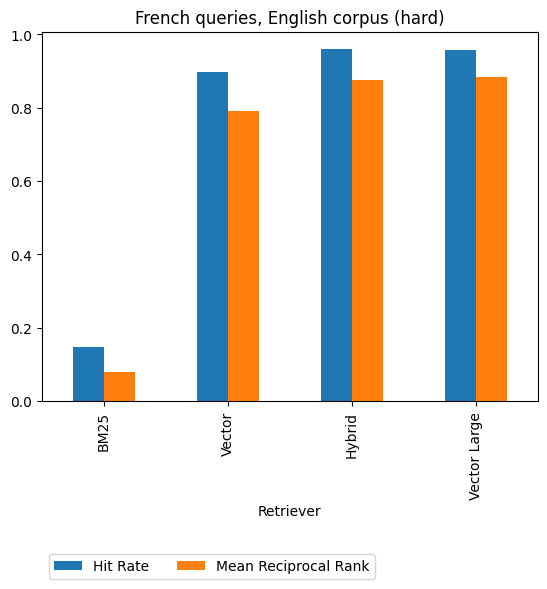

In [44]:
all_results[
    (all_results["Query language"] == "French")
    & (all_results["Corpus language"] == "English")
    & (all_results["Query difficulty"] == "Hard")
].set_index("Retriever", drop=True).plot.bar()

# Move legend to bottom left
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncol=2)
plt.title("French queries, English corpus (hard)")

Text(0.5, 1.0, 'English queries, French corpus (hard)')

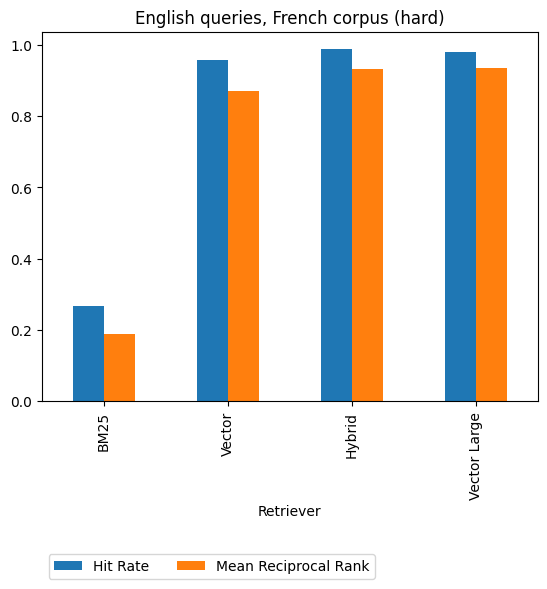

In [45]:
all_results[
    (all_results["Query language"] == "English")
    & (all_results["Corpus language"] == "French")
    & (all_results["Query difficulty"] == "Hard")
].set_index("Retriever", drop=True).plot.bar()

# Move legend to bottom left
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncol=2)
plt.title("English queries, French corpus (hard)")